In [1]:
import numpy as np
import pandas as pd 
import xgboost as xgb
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import seaborn as sns
from nltk import word_tokenize, pos_tag
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from nltk.stem import PorterStemmer, WordNetLemmatizer

/home/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def plot_distribution_feature(df, fname, label_col='is_duplicate'):
    fig = plt.figure(figsize=(16,12))
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(df[fname], bins=50, ax=ax1)    
    sns.distplot(df.loc[df[label_col]==1][fname], bins=50, ax=ax2, label='positive')    
    sns.distplot(df.loc[df[label_col]==0][fname], bins=50, ax=ax2, label='negative')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, x=label_col, data=df, ax=ax3)
    sns.violinplot(y=fname, x=label_col, data=df, ax=ax4)
    plt.show()

In [3]:
train_data = pd.read_csv('data/train.csv', index_col='id')
train_data = train_data.fillna("")
train_data.shape

(404290, 5)

In [189]:
test_data = pd.read_csv('data/test.csv', index_col='test_id')
test_data = test_data.fillna("")
test_data.shape

(2345796, 2)

## create simple word features

In [4]:
def text_cleaner(text):
    # Lower case
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9'-]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r" n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r" e-mail", " email", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"(^| ).( |$)", " ", text)
    
    # Remove unused space
    text = text.strip()
    
    return(text)

In [7]:
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def try_stem(word):
    try:
        return stemmer.stem(word)
    except:
        return word
    
def try_lem(word):
    try:
        return lemmatiser.lematize(word)
    except:
        return word

def stem_lem_text(text):
    words = word_tokenize(text)
    # stemmer
    stemmed_words = [try_stem(word) for word in words]
    stemmed_text = " ".join(stemmed_words)
    # lemmatiser
    lemmatized_words = [try_lem(word) for word in words]
    lemmatized_text = " ".join(lemmatized_words)
    
    return pd.Series([stemmed_text, lemmatized_text])

In [5]:
# clean data and stem-lemma
typ = 'clean'
for i in range(1,3):
    # clean
    print("cleanning question" +str(i))
    train_data['clean_question'+str(i)] = train_data['question'+str(i)].apply(text_cleaner)

cleanning question1
cleanning question2


In [9]:
stops = stopwords.words("english")
for i in range(1,3):
    print(typ+" len and nb words"+str(i))
    train_data[typ+'_len'+str(i)] = train_data[typ+'_question'+str(i)].str.len()
    train_data[typ+'_words'+str(i)] = train_data[typ+'_question'+str(i)].str.split()
    train_data[typ+'_nb_words'+str(i)] = train_data[typ+'_words'+str(i)].apply(len)

    print(typ+" question stop" +str(i))
    train_data[typ+'_words_stop'+str(i)] = train_data[typ+'_words'+str(i)].apply(
                                                lambda words: [w for w in words if not w in stops])
    train_data[typ+'_nb_words_stop'+str(i)] = train_data[typ+'_words_stop'+str(i)].apply(len)
    train_data[typ+'_question_stop'+str(i)] = train_data[typ+'_words_stop'+str(i)].apply(lambda x: " ".join(x))
    train_data[typ+'_len_stop'+str(i)] = train_data[typ+'_question_stop'+str(i)].str.len()

clean len and nb words1
clean question stop1
clean len and nb words2
clean question stop2


In [10]:
for cat,stop in itertools.product(['len','nb_words'],['','_stop']):
    train_data[typ+'_'+'min_'+cat+stop] = np.minimum(train_data[typ+'_'+cat+stop+'1'],
                                                     train_data[typ+'_'+cat+stop+'2'])
    train_data[typ+'_'+'max_'+cat+stop] = np.maximum(train_data[typ+'_'+cat+stop+'1'],
                                                     train_data[typ+'_'+cat+stop+'2'])
    train_data[typ+'_'+'abs_diff_'+cat+stop] = np.abs(train_data[typ+'_'+cat+stop+'1'] - 
                                                      train_data[typ+'_'+cat+stop+'2'])
    train_data[typ+'_'+'abs_diff_'+cat+stop] = (np.abs(train_data[typ+'_'+cat+stop+'1'] - 
                                                       train_data[typ+'_'+cat+stop+'2']) /
                                                np.maximum(1,(train_data[typ+'_'+cat+stop+'1'] + 
                                                              train_data[typ+'_'+cat+stop+'2'])))

In [11]:
import difflib, Levenshtein, distance

def multiple_distance(string1,string2):
    try:
        diff = difflib.SequenceMatcher(None, string1, string2).ratio()
        leve = Levenshtein.ratio(string1, string2)
        sore = 1 - distance.sorensen(string1, string2)
        jacc = 1 - distance.jaccard(string1, string2)
    except:
        diff,leve,sore,jacc = 0,0,0,0
    return pd.Series([diff,leve,sore,jacc])

for stop in ['','_stop']:
    print(typ+' multiple distance '+stop)
    train_data[[typ+'_diff'+stop,typ+'_leve'+stop,typ+'_sore'+stop,typ+'_jacc'+stop]] = train_data[
        [typ+'_question'+stop+'1',typ+'_question'+stop+'2']].apply(
        lambda x: multiple_distance(x[typ+'_question'+stop+'1'], x[typ+'_question'+stop+'2']),axis=1)

clean multiple distance 
clean multiple distance _stop


## words type

In [79]:
def word_share_tokenized(words1,words2):
    
    w1 = set(words1)
    w2 = set(words2)
    
    shared = w1 & w2
    diff = w1 ^ w2
    
    w1_stop = w1 - stops_set
    w2_stop = w2 - stops_set
    
    shared_stop = w1_stop & w2_stop
    diff_stop = w1_stop ^ w2_stop
    
    return pd.Series([shared, diff, shared_stop, diff_stop])

print(typ+' set word ')
train_data[[typ+'_common_set',typ+'_diff_set',typ+'_common_set_stop', typ+'_diff_set_stop']] = train_data.apply(
    lambda x: word_share_tokenized(x[typ+'_words1'],x[typ+'_words2']), axis=1)

clean set word 


In [80]:
print(typ+' common pos word ')
train_data[typ+'_common_pos'] = train_data[typ+'_common_set_stop'].apply(pos_tag)
print(typ+' diff pos word ')
train_data[typ+'_diff_pos'] = train_data[typ+'_diff_set_stop'].apply(pos_tag)

clean pos word 


In [81]:
def count_tags(pos_tags):
    types = [tag[1][:2] for tag in pos_tags]
    res = [types.count(tag) for tag in ['NN','JJ','RB','VB']]
    return pd.Series(res)

print(typ+' count pos word ')
train_data[[typ+'_NN_diff',typ+'_JJ_diff',
            typ+'_RB_diff',typ+'_VB_diff']] = train_data[typ+'_diff_pos'].apply(count_tags)
train_data[[typ+'_NN_common',typ+'_JJ_common',
            typ+'_RB_common',typ+'_VB_common']] = train_data[typ+'_common_pos'].apply(count_tags)

clean count pos word 


In [82]:
for tag in ['NN','JJ','RB','VB']:
    train_data[typ+'_'+tag+'_diff_norm'] = (train_data[typ+'_'+tag+'_diff'] / 
                                          np.maximum(1.0, train_data[typ+'_'+tag+'_diff'] + 
                                                     train_data[typ+'_'+tag+'_common']))

In [83]:
for stop in ['','_stop']:
    print(typ+' set word '+stop)
    train_data[typ+'_common_set_len'+stop] = train_data[typ+'_common_set'+stop].apply(len)
    train_data[typ+'_diff_set_len'+stop] = train_data[typ+'_diff_set'+stop].apply(len)

clean set word 
clean set word _stop


In [174]:
for tag in ['NN','JJ','RB','VB']:
    train_data[typ+'_'+tag+'_diff_norm_ll'] = (train_data[typ+'_'+tag+'_diff'] / 
                                                    train_data[typ+'_diff_set_len_stop'])
    train_data[typ+'_'+tag+'_common_norm_ll'] = (train_data[typ+'_'+tag+'_common'] / 
                                                    train_data[typ+'_common_set_len_stop'])
    train_data[typ+'_'+tag+'_diff_norm_lll'] = (train_data[typ+'_'+tag+'_diff'] / 
                                                     (train_data[typ+'_diff_set_len_stop'] + 
                                                      train_data[typ+'_common_set_len_stop']))

In [131]:
train_data[typ+'_stop_common_ratio'] = train_data[typ+'_common_set_len_stop'] / train_data[typ+'_common_set_len']
train_data[typ+'_stop_diff_ratio'] = train_data[typ+'_diff_set_len_stop'] / train_data[typ+'_diff_set_len']
train_data[typ+'_word_share_stop'] = train_data[typ+'_common_set_len_stop'] / (train_data[typ+'_diff_set_len_stop'] +
                                                                             train_data[typ+'_common_set_len_stop'])
train_data[typ+'_word_share'] = train_data[typ+'_common_set_len'] / (train_data[typ+'_diff_set_len'] +
                                                                        train_data[typ+'_common_set_len'])

In [145]:
def bigrams(words):
    if len(words) > 1:
        return [i for i in zip(words[:-1], words[1:])]
    else:
        return []
    
def trigrams(words):
    if len(words) > 2:
        return [i for i in zip(words[:-2], words[1:-1], words[2:])]
    else:
        return [] 

def word_share_bigrams(words1,words2):
    
    b1 = bigrams(words1)
    b2 = bigrams(words2)
    
    w1 = set(b1)
    w2 = set(b2)
    
    shared = len(w1 & w2)
    diff = len(w1 ^ w2)
    
    return pd.Series([shared/max(shared+diff,1), shared/max(len(b1)+len(b2),1)])

def word_share_trigrams(words1,words2):
    
    b1 = trigrams(words1)
    b2 = trigrams(words2)
    
    w1 = set(b1)
    w2 = set(b2)
    
    shared = len(w1 & w2)
    diff = len(w1 ^ w2)
    
    return pd.Series([shared/max(shared+diff,1), shared/max(len(b1)+len(b2),1)])

train_data[[typ+'_shared_bigrams_jac',typ+'_shared_bigram_dice']] = train_data.apply(
    lambda x: word_share_bigrams(x[typ+'_words1'],x[typ+'_words2']), axis=1)
train_data[[typ+'_shared_trigrams_jac',typ+'_shared_trigram_dice']] = train_data.apply(
    lambda x: word_share_trigrams(x[typ+'_words1'],x[typ+'_words2']), axis=1)

In [155]:
def word_hamming(words1,words2):
    return sum(1 for i in zip(words1, words2) if i[0]==i[1])/max(len(words1), len(words2))

train_data[typ+'_word_hamming'] = train_data.apply(
    lambda x: word_hamming(x[typ+'_words1'],x[typ+'_words2']), axis=1)

In [ ]:
from collections import Counter

def get_weight(count, eps=10000, min_count=2):
    return 0 if count < min_count else 1 / (count + eps)

train_qs = pd.Series(train_data['clean_question1'].tolist() + train_data['clean_question2'].tolist()).astype(str)
words = (" ".join(train_qs)).split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

def idf_word_share(common_set, diff_set):
    common_weight =[weights.get(w, 0) for w in common_set]
    diff_weight =[weights.get(w, 0) for w in diff_set]
    return np.sum(common_weight)/(np.sum(common_weight)+np.sum(diff_weight))

print('idf word share')
train_data[typ+'_idf_word_share_stop'] = train_data.apply(lambda x: idf_word_share(x[typ+'_common_set_stop'],
                                                                                  x[typ+'_diff_set_stop']),axis=1)
train_data[typ+'_idf_word_share'] = train_data.apply(lambda x: idf_word_share(x[typ+'_common_set'],
                                                                                  x[typ+'_diff_set']),axis=1)

## tf-idf features

In [6]:
stops = stopwords.words("english")

def cosine_vectors(vec1,vec2):
    
    norm_v1 = np.array(np.sqrt(vec1.multiply(vec1).sum(axis=1)))[:, 0]
    norm_v2 = np.array(np.sqrt(vec2.multiply(vec2).sum(axis=1)))[:, 0]
    num = np.array(vec1.multiply(vec2).sum(axis=1))[:, 0]
    den = norm_v1 * norm_v2
    
    num[np.where(den == 0)] = 1
    den[np.where(den == 0)] = 1

    v_score = 1 - num/den
    
    return v_score.astype(float)

def l1_norm(vec1,vec2):
    return np.array(np.abs(vec1 - vec2).sum(axis=1))[:, 0]

def l2_norm(vec1,vec2):
    vec_diff = vec1 - vec2
    return np.array(vec1.multiply(vec1).sum(axis=1))[:, 0]
    

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import additive_chi2_kernel

In [7]:
questions = pd.concat([train_data['clean_question1'],train_data['clean_question2']]).unique()
tfidf1_gram = TfidfVectorizer(stop_words=stops,
                        analyzer='word',use_idf=True,
                        smooth_idf=True,min_df=10,max_df=0.99,ngram_range=(1,1)).fit(questions)

clean_v1 = tfidf1_gram.transform(train_data.ix[:,'clean_question1'])
clean_v2 = tfidf1_gram.transform(train_data.ix[:,'clean_question2'])

train_data['tf-idf-cosine_clean_one_gram'] = cosine_vectors(clean_v1,clean_v2)

In [10]:
cosine_similarity(clean_v1[1],clean_v2[1])

array([[ 0.69592934]])

In [12]:
norm_v1 = np.array(np.sqrt(clean_v1.multiply(clean_v1).sum(axis=1)))[:, 0]

In [23]:
np.array(np.abs(clean_v1 - clean_v2).sum(axis=1))[:, 0]

array([ 0.23262454,  2.24884017,  3.18442788, ...,  0.54946621,
        6.12323386,  0.        ])

In [90]:
questions = pd.concat([train_data['clean_question1'],train_data['clean_question2']]).unique()
tfidf2_gram = TfidfVectorizer(analyzer='word',use_idf=True,
                        smooth_idf=True,min_df=25,max_df=0.95,ngram_range=(2,2)).fit(questions)

clean_v1 = tfidf2_gram.transform(train_data.ix[:,'clean_question1'])
clean_v2 = tfidf2_gram.transform(train_data.ix[:,'clean_question2'])

train_data['tf-idf-cosine_clean_two_gram'] = cosine_vectors(clean_v1,clean_v2)

In [91]:
questions = pd.concat([train_data['clean_question1'],train_data['clean_question2']]).unique()
tfidf3_gram = TfidfVectorizer(analyzer='word',use_idf=True,
                        smooth_idf=True,min_df=10,max_df=0.95,ngram_range=(3,3)).fit(questions)

clean_v1 = tfidf3_gram.transform(train_data.ix[:,'clean_question1'])
clean_v2 = tfidf3_gram.transform(train_data.ix[:,'clean_question2'])

train_data['tf-idf-cosine_clean_three_gram'] = cosine_vectors(clean_v1,clean_v2)

In [92]:
questions = pd.concat([train_data['clean_question1'],train_data['clean_question2']]).unique()
tfidf = TfidfVectorizer(stop_words=stops,
                        analyzer='word',use_idf=True,
                        smooth_idf=True,min_df=50,max_df=0.95,ngram_range=(1,3)).fit(questions)

clean_v1 = tfidf.transform(train_data.ix[:,'clean_question1'])
clean_v2 = tfidf.transform(train_data.ix[:,'clean_question2'])

train_data['tf-idf-cosine_clean'] = cosine_vectors(clean_v1,clean_v2)

In [175]:
cols = [col for col in train_data.columns if ('1' not in col and '2' not in col)][1:]
usable_cols = [col for col in cols if train_data[col].dtype != object]

In [177]:
train_data[usable_cols].to_csv('data/clean_features.csv')

In [178]:
x_train = train_data.ix[0:350000,usable_cols]
x_test = train_data.ix[350000:,usable_cols]
y_train = train_data.ix[0:350000,'is_duplicate']
y_test = train_data.ix[350000:,'is_duplicate']

In [179]:
from sklearn.metrics import log_loss, make_scorer

xgb_params = {
    'max_depth': 7, 
    'learning_rate': 0.1,
    'n_estimators': 300, 
    'objective': 'binary:logistic',
    'nthread': 8, 
    'gamma': 0, 
    'subsample': 0.75, 
    'colsample_bytree': 0.75, 
    'colsample_bylevel': 1,
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': 1
}

model = xgb.XGBClassifier(silent=False).set_params(**xgb_params)

In [180]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.75,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=300, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.75)

In [181]:
proba = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)

0.872095690868
0.412559732181


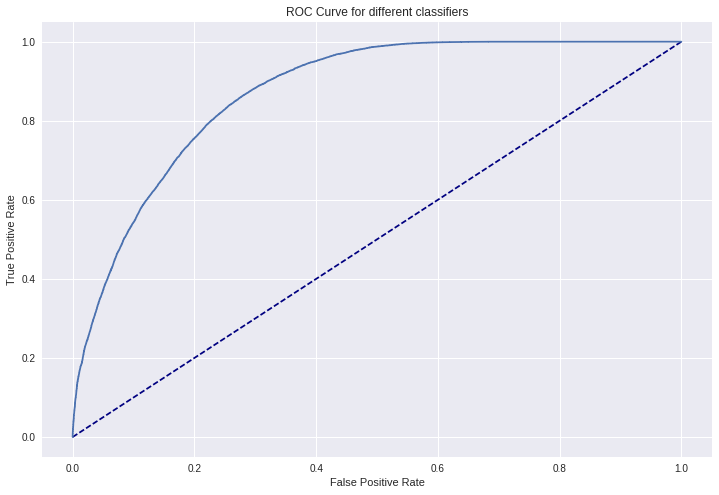

In [182]:
from sklearn.metrics import log_loss, make_scorer
plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)
print(roc_auc)
print(log_loss(y_test,proba))
plt.plot(fpr, tpr)

In [183]:
fi = pd.DataFrame([(usable_cols[i],model.feature_importances_[i]) for i in range(len(usable_cols))], columns=['feature','ímportance'])
fi = fi.sort_values(fi.columns[1],ascending=True)
fi.plot(kind='barh',x='feature',y='ímportance',figsize=(16,40),sort_columns=True)

In [191]:
# clean data and stem-lemma
typ = 'clean'
for i in range(1,3):
    # clean
    print("cleanning question" +str(i))
    test_data['clean_question'+str(i)] = test_data['question'+str(i)].apply(text_cleaner)

cleanning question1
cleanning question2


In [192]:
for i in range(1,3):
    print(typ+" len and nb words"+str(i))
    test_data[typ+'_len'+str(i)] = test_data[typ+'_question'+str(i)].str.len()
    test_data[typ+'_words'+str(i)] = test_data[typ+'_question'+str(i)].str.split()
    test_data[typ+'_nb_words'+str(i)] = test_data[typ+'_words'+str(i)].apply(len)

    print(typ+" question stop" +str(i))
    test_data[typ+'_words_stop'+str(i)] = test_data[typ+'_words'+str(i)].apply(
                                                lambda words: [w for w in words if not w in stops])
    test_data[typ+'_nb_words_stop'+str(i)] = test_data[typ+'_words_stop'+str(i)].apply(len)
    test_data[typ+'_question_stop'+str(i)] = test_data[typ+'_words_stop'+str(i)].apply(lambda x: " ".join(x))
    test_data[typ+'_len_stop'+str(i)] = test_data[typ+'_question_stop'+str(i)].str.len()

clean len and nb words1
clean question stop1
clean len and nb words2
clean question stop2


In [193]:
for cat,stop in itertools.product(['len','nb_words'],['','_stop']):
    test_data[typ+'_'+'min_'+cat+stop] = np.minimum(test_data[typ+'_'+cat+stop+'1'],
                                                     test_data[typ+'_'+cat+stop+'2'])
    test_data[typ+'_'+'max_'+cat+stop] = np.maximum(test_data[typ+'_'+cat+stop+'1'],
                                                     test_data[typ+'_'+cat+stop+'2'])
    test_data[typ+'_'+'abs_diff_'+cat+stop] = np.abs(test_data[typ+'_'+cat+stop+'1'] - 
                                                      test_data[typ+'_'+cat+stop+'2'])
    test_data[typ+'_'+'abs_diff_'+cat+stop] = (np.abs(test_data[typ+'_'+cat+stop+'1'] - 
                                                       test_data[typ+'_'+cat+stop+'2']) /
                                                np.maximum(1,(test_data[typ+'_'+cat+stop+'1'] + 
                                                              test_data[typ+'_'+cat+stop+'2'])))

In [194]:
for stop in ['','_stop']:
    print(typ+' multiple distance '+stop)
    test_data[[typ+'_diff'+stop,typ+'_leve'+stop,typ+'_sore'+stop,typ+'_jacc'+stop]] = test_data[
        [typ+'_question'+stop+'1',typ+'_question'+stop+'2']].apply(
        lambda x: multiple_distance(x[typ+'_question'+stop+'1'], x[typ+'_question'+stop+'2']),axis=1)

clean multiple distance 
clean multiple distance _stop


In [195]:
print(typ+' set word ')
test_data[[typ+'_common_set',typ+'_diff_set',typ+'_common_set_stop', typ+'_diff_set_stop']] = test_data.apply(
    lambda x: word_share_tokenized(x[typ+'_words1'],x[typ+'_words2']), axis=1)
print(typ+' common pos word ')
test_data[typ+'_common_pos'] = test_data[typ+'_common_set_stop'].apply(pos_tag)
print(typ+' diff pos word ')
test_data[typ+'_diff_pos'] = test_data[typ+'_diff_set_stop'].apply(pos_tag)
print(typ+' count pos word ')
test_data[[typ+'_NN_diff',typ+'_JJ_diff',
            typ+'_RB_diff',typ+'_VB_diff']] = test_data[typ+'_diff_pos'].apply(count_tags)
test_data[[typ+'_NN_common',typ+'_JJ_common',
            typ+'_RB_common',typ+'_VB_common']] = test_data[typ+'_common_pos'].apply(count_tags)

clean set word 
clean common pos word 
clean diff pos word 
clean count pos word 


In [196]:
print("done")

done


In [197]:
for stop in ['','_stop']:
    print(typ+' set word '+stop)
    test_data[typ+'_common_set_len'+stop] = test_data[typ+'_common_set'+stop].apply(len)
    test_data[typ+'_diff_set_len'+stop] = test_data[typ+'_diff_set'+stop].apply(len)

clean set word 
clean set word _stop


In [198]:
for tag in ['NN','JJ','RB','VB']:
    test_data[typ+'_'+tag+'_diff_norm'] = (test_data[typ+'_'+tag+'_diff'] / 
                                          np.maximum(1.0, test_data[typ+'_'+tag+'_diff'] + 
                                                     test_data[typ+'_'+tag+'_common']))
    test_data[typ+'_'+tag+'_diff_norm_ll'] = (test_data[typ+'_'+tag+'_diff'] / 
                                                    test_data[typ+'_diff_set_len_stop'])
    test_data[typ+'_'+tag+'_common_norm_ll'] = (test_data[typ+'_'+tag+'_common'] / 
                                                    test_data[typ+'_common_set_len_stop'])
    test_data[typ+'_'+tag+'_diff_norm_lll'] = (test_data[typ+'_'+tag+'_diff'] / 
                                                     (test_data[typ+'_diff_set_len_stop'] + 
                                                      test_data[typ+'_common_set_len_stop']))

In [199]:
test_data[typ+'_stop_common_ratio'] = test_data[typ+'_common_set_len_stop'] / test_data[typ+'_common_set_len']
test_data[typ+'_stop_diff_ratio'] = test_data[typ+'_diff_set_len_stop'] / test_data[typ+'_diff_set_len']
test_data[typ+'_word_share_stop'] = test_data[typ+'_common_set_len_stop'] / (test_data[typ+'_diff_set_len_stop'] +
                                                                             test_data[typ+'_common_set_len_stop'])
test_data[typ+'_word_share'] = test_data[typ+'_common_set_len'] / (test_data[typ+'_diff_set_len'] +
                                                                        test_data[typ+'_common_set_len'])

In [ ]:
test_data[[typ+'_shared_bigrams_jac',typ+'_shared_bigram_dice']] = test_data.apply(
    lambda x: word_share_bigrams(x[typ+'_words1'],x[typ+'_words2']), axis=1)
test_data[[typ+'_shared_trigrams_jac',typ+'_shared_trigram_dice']] = test_data.apply(
    lambda x: word_share_trigrams(x[typ+'_words1'],x[typ+'_words2']), axis=1)
test_data[typ+'_word_hamming'] = test_data.apply(
    lambda x: word_hamming(x[typ+'_words1'],x[typ+'_words2']), axis=1)

In [ ]:
print('idf word share')
test_data[typ+'_idf_word_share_stop'] = test_data.apply(lambda x: idf_word_share(x[typ+'_common_set_stop'],
                                                                                  x[typ+'_diff_set_stop']),axis=1)
test_data[typ+'_idf_word_share'] = test_data.apply(lambda x: idf_word_share(x[typ+'_common_set'],
                                                                                  x[typ+'_diff_set']),axis=1)

In [ ]:
clean_v1 = tfidf.transform(train_data.ix[:,'clean_question1'])
clean_v2 = tfidf.transform(train_data.ix[:,'clean_question2'])

train_data['tf-idf-cosine_clean'] = cosine_vectors(clean_v1,clean_v2)

In [ ]:
clean_v1 = tfidf.transform(train_data.ix[:,'clean_question1'])
clean_v2 = tfidf.transform(train_data.ix[:,'clean_question2'])

train_data['tf-idf-cosine_clean'] = cosine_vectors(clean_v1,clean_v2)

In [ ]:
clean_v1 = tfidf.transform(train_data.ix[:,'clean_question1'])
clean_v2 = tfidf.transform(train_data.ix[:,'clean_question2'])

train_data['tf-idf-cosine_clean'] = cosine_vectors(clean_v1,clean_v2)

In [ ]:
clean_v1 = tfidf.transform(train_data.ix[:,'clean_question1'])
clean_v2 = tfidf.transform(train_data.ix[:,'clean_question2'])

train_data['tf-idf-cosine_clean'] = cosine_vectors(clean_v1,clean_v2)